In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import auc, precision_score, recall_score, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

RANDOM_SEED = 1212

In [2]:
# Loads the data from the dataset CSV file
data = pd.read_csv('data/koi_data.csv')

# Makes the kepoi_name to be set as the dataframe index
data = data.set_index('kepoi_name')

# Converting the label column to boolean
data['koi_disposition'] = data['koi_disposition'] == 'CONFIRMED'

data.head(5)

,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,koi_incl,koi_teq,koi_insol,koi_dor,koi_max_sngle_ev,koi_max_mult_ev,koi_model_snr,koi_steff,koi_slogg,koi_smet,koi_srad,koi_smass,koi_kepmag,koi_gmag,koi_rmag,koi_imag,koi_zmag,koi_jmag,koi_hmag,koi_kmag,koi_fwm_stat_sig,koi_fwm_sra,koi_fwm_sdec,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
kepoi_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
K00752.01,True,9.48804,0.146,2.95750,615.8,0.02234,3.20796,2.26,0.0853,89.66,793.0,93.59,24.810,5.13585,28.47082,35.8,5455.0,4.467,0.14,0.927,0.919,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,0.002,19.46229,48.14191,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
K00752.02,True,54.41838,0.586,4.50700,874.8,0.02795,3.02368,2.83,0.2734,89.57,443.0,9.11,77.900,7.02767,20.10951,25.8,5455.0,4.467,0.14,0.927,0.919,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,0.003,19.46226,48.14199,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
K00754.01,False,1.73695,1.276,2.40641,8079.2,0.38739,0.22080,33.46,0.0267,67.09,1395.0,891.96,3.278,39.06655,541.89510,505.6,5805.0,4.564,-0.52,0.791,0.836,15.597,16.100,15.554,15.382,15.266,14.326,13.911,13.809,0.000,19.03564,48.28521,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
K00755.01,True,2.52559,0.701,1.65450,603.3,0.02406,1.98635,2.75,0.0374,85.41,1406.0,926.16,8.750,4.74994,33.19190,40.9,6031.0,4.438,0.07,1.046,1.095,15.509,16.015,15.468,15.292,15.241,14.366,14.064,13.952,0.733,19.25033,48.22626,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070
K00114.01,False,7.36179,1.169,5.02200,233.7,0.18339,0.00485,39.21,0.0820,60.92,1342.0,767.22,2.400,10.96468,46.15308,47.7,6227.0,3.986,0.00,1.958,1.358,12.660,12.999,12.609,12.515,12.480,11.659,11.415,11.396,0.000,19.92395,42.15826,-13.450,24.090,0.00303,-0.00555,-4.506,7.710,8.930,-4.537,7.713,8.948


In [3]:
# A slight unbalanced dataset (40% positives and 60% negatives)
print(data[data['koi_disposition'] == True].shape)
print(data[data['koi_disposition'] == False].shape)

(2104, 42)
(3098, 42)


In [4]:
# Separation between features (x) and labels (y)
x = data.drop('koi_disposition', axis=1)
y = data['koi_disposition']

In [5]:
# Custom function to ease the creation of models
def create_model(experiments, model_name, model_obj, model_params={}):
    experiments['model_name'].append(model_name)
    experiments['model_object'].append(model_obj(**model_params))
    experiments['model_params'].append(model_params)
    
    return experiments

## Naive Bayes baseline

In this project we'll use Naive Bayes as a baseline for our performance comparison with other models.

We're using the Gaussian Naive Bayes for this purpose.

In [6]:
experiments = {'model_name': [], 'model_object': [], 'model_params': []}

# Naive Bayes baseline creation
experiments = create_model(experiments, 'NaiveBayes', GaussianNB)

## Decision Tree experiments

Here we're using Decision Trees as models varying its max_depth parameter (tree maximum level) as an attempt to achieve better results.

As we raise the max_depth of any tree model, we'll get a more complex model, but it may be fit to a more complex data as well, however it can also be more prone to overfitting.

In [7]:
# Decision Tree experiments creation
experiments = create_model(experiments, 'DecisionTree', DecisionTreeClassifier, {'max_depth': 1})
experiments = create_model(experiments, 'DecisionTree', DecisionTreeClassifier, {'max_depth': 2})
experiments = create_model(experiments, 'DecisionTree', DecisionTreeClassifier, {'max_depth': 5})
experiments = create_model(experiments, 'DecisionTree', DecisionTreeClassifier, {'max_depth': 10})
experiments = create_model(experiments, 'DecisionTree', DecisionTreeClassifier, {'max_depth': 15})
experiments = create_model(experiments, 'DecisionTree', DecisionTreeClassifier, {'max_depth': 20})
experiments = create_model(experiments, 'DecisionTree', DecisionTreeClassifier, {'max_depth': 30})
experiments = create_model(experiments, 'DecisionTree', DecisionTreeClassifier, {'max_depth': None})

## SVM experiments

Here we're using SVM as models varying its kernel parameter.

We use a linear kernel as the simplest separation possible, then use a sigmoid separation, the use a RBF (radial basis function) and finally a polynomial function with 2, 3 and 4 degrees to see which one fits our data separation better.

We should expect that as our separation function complexity goes up, it may be well fit to our data, but also more prone to overfitting.

In [8]:
# SVM experiments creation
experiments = create_model(experiments, 'SVM', SVC, {'kernel': 'linear'})
experiments = create_model(experiments, 'SVM', SVC, {'kernel': 'sigmoid'})
experiments = create_model(experiments, 'SVM', SVC, {'kernel': 'rbf'})
experiments = create_model(experiments, 'SVM', SVC, {'kernel': 'poly', 'degree': 2})
experiments = create_model(experiments, 'SVM', SVC, {'kernel': 'poly', 'degree': 3})
experiments = create_model(experiments, 'SVM', SVC, {'kernel': 'poly', 'degree': 4})

## KNN experiments

Here we're using KNN as models varying its number of neighbors parameter (n_neighbors).

As we lower the number of this parameter, the model considers only a few close points. This may lead the model to match the data point to a small number of outliers within an broader data group.

As we raise the number of this parameter, the model considers a more broader neighbors distance. This may also lead the model to match the data point to a distance group of points, leading the model to misclassificate it.

In [9]:
# KNN experiments creation
experiments = create_model(experiments, 'KNN', KNeighborsClassifier, {'n_neighbors': 1})
experiments = create_model(experiments, 'KNN', KNeighborsClassifier, {'n_neighbors': 5})
experiments = create_model(experiments, 'KNN', KNeighborsClassifier, {'n_neighbors': 10})
experiments = create_model(experiments, 'KNN', KNeighborsClassifier, {'n_neighbors': 50})
experiments = create_model(experiments, 'KNN', KNeighborsClassifier, {'n_neighbors': 100})
experiments = create_model(experiments, 'KNN', KNeighborsClassifier, {'n_neighbors': 500})
experiments = create_model(experiments, 'KNN', KNeighborsClassifier, {'n_neighbors': 1000})

## Random Forest experiments

Here we're using Random Forest ensemble models varying its number of tree estimators (n_estimators).

As we lower the number of this parameter, less trees will be fitted and taken into account for the ensemble. If the data is simple, this strategy may give us the better results for generalization. But if the data is more complex, this stategy will result in an underfit.

As we raise the number of this parameter, more trees will be fitted and taken into account for the ensemble. If the data is simple, this strategy will probably result in an overfit. But if the data is more complex, this stategy may give us the better results.

In [10]:
# Random Forest experiments creation
experiments = create_model(experiments, 'RandomForest', RandomForestClassifier, {'n_estimators': 1})
experiments = create_model(experiments, 'RandomForest', RandomForestClassifier, {'n_estimators': 5})
experiments = create_model(experiments, 'RandomForest', RandomForestClassifier, {'n_estimators': 10})
experiments = create_model(experiments, 'RandomForest', RandomForestClassifier, {'n_estimators': 50})
experiments = create_model(experiments, 'RandomForest', RandomForestClassifier, {'n_estimators': 100})
experiments = create_model(experiments, 'RandomForest', RandomForestClassifier, {'n_estimators': 200})
experiments = create_model(experiments, 'RandomForest', RandomForestClassifier, {'n_estimators': 500})

## Gradient Tree Boosting experiments

Here we're using Gradient Tree Boosting ensemble models varying its number of tree estimators (n_estimators).

As we lower the number of this parameter, less trees will be fitted and taken into account for the ensemble. If the data is simple, this strategy may give us the better results for generalization. But if the data is more complex, this stategy will result in an underfit.

As we raise the number of this parameter, more trees will be fitted and taken into account for the ensemble. If the data is simple, this strategy will probably result in an overfit. But if the data is more complex, this stategy may give us the better results.

In [11]:
# Gradient Tree Boosting experiments creation
experiments = create_model(experiments, 'GradientTreeBoosting', GradientBoostingClassifier, {'n_estimators': 1})
experiments = create_model(experiments, 'GradientTreeBoosting', GradientBoostingClassifier, {'n_estimators': 5})
experiments = create_model(experiments, 'GradientTreeBoosting', GradientBoostingClassifier, {'n_estimators': 10})
experiments = create_model(experiments, 'GradientTreeBoosting', GradientBoostingClassifier, {'n_estimators': 50})
experiments = create_model(experiments, 'GradientTreeBoosting', GradientBoostingClassifier, {'n_estimators': 100})
experiments = create_model(experiments, 'GradientTreeBoosting', GradientBoostingClassifier, {'n_estimators': 200})
experiments = create_model(experiments, 'GradientTreeBoosting', GradientBoostingClassifier, {'n_estimators': 500})

In [12]:
# Function to ease the creation of a model pipeline, by attaching it to a Standard Scaler
def create_pipeline(model):
    pipe = Pipeline([['std', StandardScaler()],
                     ['clf', model]])

    return pipe

In [13]:
# Apply the create_pipeline function to each model experiment
experiments['pipeline'] = list(map(lambda model: create_pipeline(model), experiments['model_object']))

In [14]:
# Executes the cross_val_score with accuracy score and 5-fold cross validation to each of our experiments
experiments['accuracy_scores'] = list(map(
    lambda pipeline: cross_val_score(pipeline, x, y, cv=5, scoring='accuracy', n_jobs=-1),experiments['pipeline']))

In [15]:
# Calculates the mean of each model accuracy score
experiments['accuracy_mean'] = list(map(lambda scores: np.mean(scores), experiments['accuracy_scores']))

In [16]:
# Puts all the results into a dataframe
results = pd.DataFrame(experiments)
results.head(results.shape[0])

,model_name,model_object,model_params,pipeline,accuracy_scores,accuracy_mean
0,NaiveBayes,GaussianNB(),{},"(StandardScaler(), GaussianNB())","[0.899135446685879, 0.9087415946205571, 0.9288...",0.918883
1,DecisionTree,DecisionTreeClassifier(max_depth=1),{'max_depth': 1},"(StandardScaler(), DecisionTreeClassifier(max_...","[0.808837656099904, 0.765609990393852, 0.75865...",0.724313
2,DecisionTree,DecisionTreeClassifier(max_depth=2),{'max_depth': 2},"(StandardScaler(), DecisionTreeClassifier(max_...","[0.8165225744476465, 0.8242074927953891, 0.931...",0.864877
3,DecisionTree,DecisionTreeClassifier(max_depth=5),{'max_depth': 5},"(StandardScaler(), DecisionTreeClassifier(max_...","[0.9241114313160422, 0.9500480307396734, 0.955...",0.942909
4,DecisionTree,DecisionTreeClassifier(max_depth=10),{'max_depth': 10},"(StandardScaler(), DecisionTreeClassifier(max_...","[0.9221902017291066, 0.9500480307396734, 0.948...",0.939063
5,DecisionTree,DecisionTreeClassifier(max_depth=15),{'max_depth': 15},"(StandardScaler(), DecisionTreeClassifier(max_...","[0.9279538904899135, 0.9481268011527377, 0.950...",0.940408
6,DecisionTree,DecisionTreeClassifier(max_depth=20),{'max_depth': 20},"(StandardScaler(), DecisionTreeClassifier(max_...","[0.9279538904899135, 0.9558117195004803, 0.955...",0.941561
7,DecisionTree,DecisionTreeClassifier(max_depth=30),{'max_depth': 30},"(StandardScaler(), DecisionTreeClassifier(max_...","[0.9250720461095101, 0.9452449567723343, 0.951...",0.937910
8,DecisionTree,DecisionTreeClassifier(),{'max_depth': None},"(StandardScaler(), DecisionTreeClassifier())","[0.9250720461095101, 0.9481268011527377, 0.953...",0.939832
9,SVM,SVC(kernel='linear'),{'kernel': 'linear'},"(StandardScaler(), SVC(kernel='linear'))","[0.9154658981748319, 0.9567723342939481, 0.968...",0.949448


In [17]:
# Prints the experiments sorting it by accuracy_mean in descending order
sorted_results = results[['model_name', 'model_params', 'accuracy_mean']].sort_values('accuracy_mean',
                                                                                      ascending=False)
sorted_results.head(sorted_results.shape[0])

,model_name,model_params,accuracy_mean
35,GradientTreeBoosting,{'n_estimators': 500},0.969247
34,GradientTreeBoosting,{'n_estimators': 200},0.968861
28,RandomForest,{'n_estimators': 500},0.967706
26,RandomForest,{'n_estimators': 100},0.966169
33,GradientTreeBoosting,{'n_estimators': 100},0.965594
25,RandomForest,{'n_estimators': 50},0.965401
27,RandomForest,{'n_estimators': 200},0.964823
32,GradientTreeBoosting,{'n_estimators': 50},0.963286
24,RandomForest,{'n_estimators': 10},0.960977
23,RandomForest,{'n_estimators': 5},0.953674


## Results analysis

* Naive Bayes: The simpler model possible in this project also achieves a relatively high accuracy $\approx 92%$. So we can use this as a baseline comparison with other models.

* Decision Tree: As we can see, the top accuracy model is the one with the lesser max_depth parameter and all the others with higher max_depths were similar in its accuracy. So we can conclude that the data can be well expressed with a relatively small decision tree (max_depth=5) for a great part of it, achieving $\approx 94\%$ accuracy and thus making us believe that its separation for the most part of label groups is simple.

* SVM: The SVM with the linear and RBF kernel were the topmost model accuracies achieved, lowering more and more as we add complexity to the model (e.g. separation with a 4th degree polynomial). This leads us to believe that the data is not very complex to separate in its majority, as we can also achieve $\approx 94\%$ accuracy with these simpler models.

* KNN: All the KNN models performed worse than the Naive Bayes baseline model by at least $\approx 3\%$, making us believe that this kind of model is not well-fit for this data. This can be happening because some data points is mixed into a group of different class, making this model a bad predictor.

* Random Forest: The more complexity we added to the Random Forest model, the higher accuracy we achieved. But even the simplest model possible (with only one tree estimator) got a higher accuracy than our Naive Bayes baseline. This makes us believe that the data itself is very simple to separate by a single tree, but there are a few data points that are more complex to separate than others, requiring a more complex model (higher n_estimators) to achieve better results.

* Gradient Tree Boosting: The more complexity we added to the Gradient Tree Boosting model, the higher accuracy we achieved. But even simpler models p (with only five tree estimators) got a higher accuracy than our Naive Bayes baseline. This makes us believe that the data itself is very simple to separate by a few set of trees, but there are a few data points that are more complex to separate than others, requiring a more complex model (higher n_estimators) to achieve better results. This proves even more the past Random Forest experiment conclusion.

In [18]:
# Splits the data into 80% train and 20% test
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=RANDOM_SEED)

In [19]:
results['fitted_pipeline'] = list(map(lambda pipeline: pipeline.fit(train_x, train_y), experiments['pipeline']))

In [20]:
results['y_pred'] = list(map(lambda pipeline: pipeline.predict(test_x), experiments['pipeline']))

----------------------------------------------------------------------------------------------------
Results for NaiveBayes with parameters {}
Precision macro = 0.911
Precision for class 0 (False Positive) = 0.984
Precision for class 1 (Confirmed) = 0.839
Recall macro = 0.929
Recall for class 0 (False Positive) = 0.881
Recall for class 1 (Confirmed) = 0.978


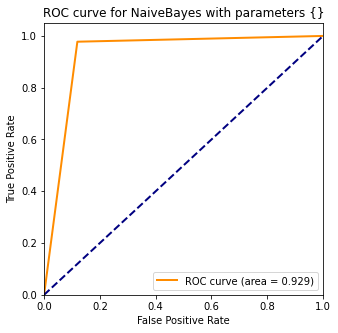

----------------------------------------------------------------------------------------------------
Results for DecisionTree with parameters {'max_depth': 1}
Precision macro = 0.765
Precision for class 0 (False Positive) = 0.956
Precision for class 1 (Confirmed) = 0.573
Recall macro = 0.753
Recall for class 0 (False Positive) = 0.546
Recall for class 1 (Confirmed) = 0.960


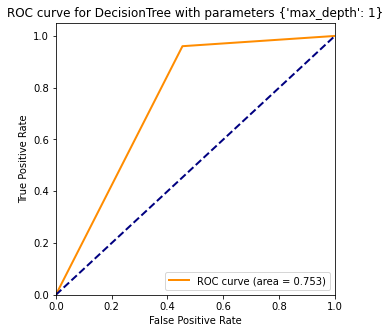

----------------------------------------------------------------------------------------------------
Results for DecisionTree with parameters {'max_depth': 2}
Precision macro = 0.896
Precision for class 0 (False Positive) = 0.970
Precision for class 1 (Confirmed) = 0.822
Recall macro = 0.913
Recall for class 0 (False Positive) = 0.868
Recall for class 1 (Confirmed) = 0.958


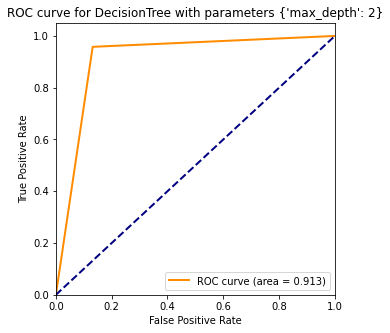

----------------------------------------------------------------------------------------------------
Results for DecisionTree with parameters {'max_depth': 5}
Precision macro = 0.932
Precision for class 0 (False Positive) = 0.974
Precision for class 1 (Confirmed) = 0.890
Recall macro = 0.943
Recall for class 0 (False Positive) = 0.925
Recall for class 1 (Confirmed) = 0.960


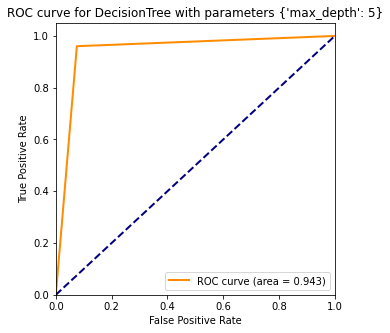

----------------------------------------------------------------------------------------------------
Results for DecisionTree with parameters {'max_depth': 10}
Precision macro = 0.945
Precision for class 0 (False Positive) = 0.973
Precision for class 1 (Confirmed) = 0.917
Recall macro = 0.951
Recall for class 0 (False Positive) = 0.945
Recall for class 1 (Confirmed) = 0.958


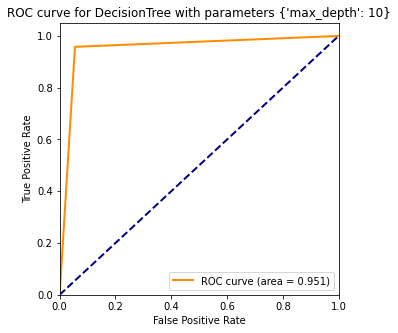

----------------------------------------------------------------------------------------------------
Results for DecisionTree with parameters {'max_depth': 15}
Precision macro = 0.947
Precision for class 0 (False Positive) = 0.974
Precision for class 1 (Confirmed) = 0.919
Recall macro = 0.954
Recall for class 0 (False Positive) = 0.947
Recall for class 1 (Confirmed) = 0.960


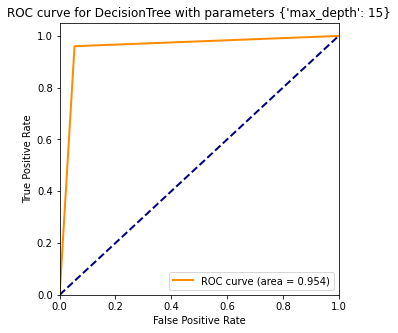

----------------------------------------------------------------------------------------------------
Results for DecisionTree with parameters {'max_depth': 20}
Precision macro = 0.942
Precision for class 0 (False Positive) = 0.969
Precision for class 1 (Confirmed) = 0.914
Recall macro = 0.948
Recall for class 0 (False Positive) = 0.943
Recall for class 1 (Confirmed) = 0.953


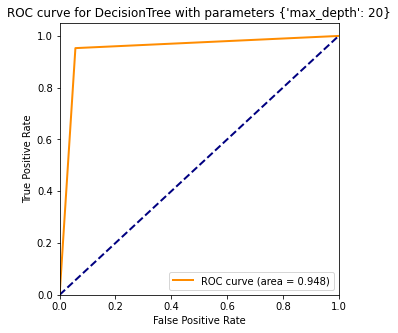

----------------------------------------------------------------------------------------------------
Results for DecisionTree with parameters {'max_depth': 30}
Precision macro = 0.932
Precision for class 0 (False Positive) = 0.961
Precision for class 1 (Confirmed) = 0.903
Recall macro = 0.938
Recall for class 0 (False Positive) = 0.936
Recall for class 1 (Confirmed) = 0.941


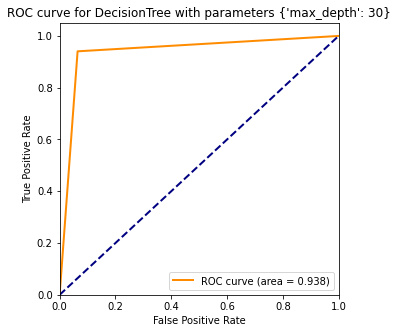

----------------------------------------------------------------------------------------------------
Results for DecisionTree with parameters {'max_depth': None}
Precision macro = 0.939
Precision for class 0 (False Positive) = 0.969
Precision for class 1 (Confirmed) = 0.908
Recall macro = 0.946
Recall for class 0 (False Positive) = 0.939
Recall for class 1 (Confirmed) = 0.953


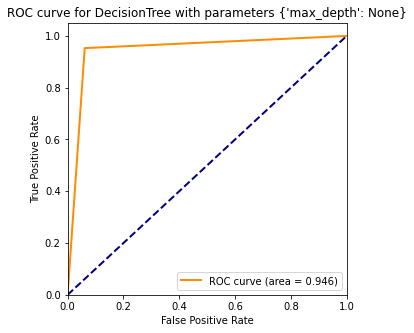

----------------------------------------------------------------------------------------------------
Results for SVM with parameters {'kernel': 'linear'}
Precision macro = 0.947
Precision for class 0 (False Positive) = 0.979
Precision for class 1 (Confirmed) = 0.916
Recall macro = 0.956
Recall for class 0 (False Positive) = 0.943
Recall for class 1 (Confirmed) = 0.968


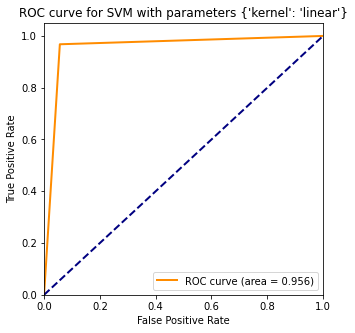

----------------------------------------------------------------------------------------------------
Results for SVM with parameters {'kernel': 'sigmoid'}
Precision macro = 0.857
Precision for class 0 (False Positive) = 0.890
Precision for class 1 (Confirmed) = 0.825
Recall macro = 0.858
Recall for class 0 (False Positive) = 0.889
Recall for class 1 (Confirmed) = 0.827


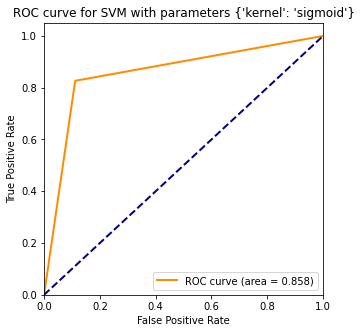

----------------------------------------------------------------------------------------------------
Results for SVM with parameters {'kernel': 'rbf'}
Precision macro = 0.935
Precision for class 0 (False Positive) = 0.982
Precision for class 1 (Confirmed) = 0.889
Recall macro = 0.948
Recall for class 0 (False Positive) = 0.923
Recall for class 1 (Confirmed) = 0.973


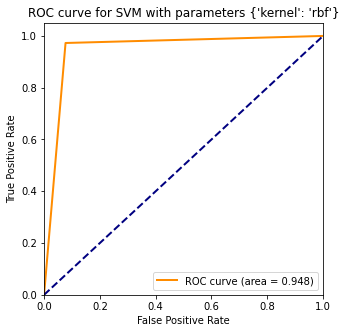

----------------------------------------------------------------------------------------------------
Results for SVM with parameters {'kernel': 'poly', 'degree': 2}
Precision macro = 0.902
Precision for class 0 (False Positive) = 0.972
Precision for class 1 (Confirmed) = 0.833
Recall macro = 0.919
Recall for class 0 (False Positive) = 0.878
Recall for class 1 (Confirmed) = 0.960


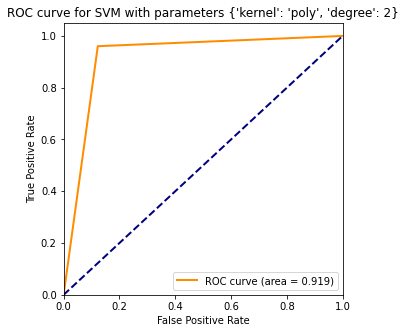

----------------------------------------------------------------------------------------------------
Results for SVM with parameters {'kernel': 'poly', 'degree': 3}
Precision macro = 0.865
Precision for class 0 (False Positive) = 0.986
Precision for class 1 (Confirmed) = 0.743
Recall macro = 0.884
Recall for class 0 (False Positive) = 0.785
Recall for class 1 (Confirmed) = 0.983


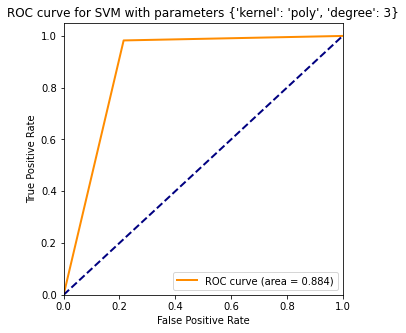

----------------------------------------------------------------------------------------------------
Results for SVM with parameters {'kernel': 'poly', 'degree': 4}
Precision macro = 0.802
Precision for class 0 (False Positive) = 0.990
Precision for class 1 (Confirmed) = 0.614
Recall macro = 0.798
Recall for class 0 (False Positive) = 0.606
Recall for class 1 (Confirmed) = 0.990


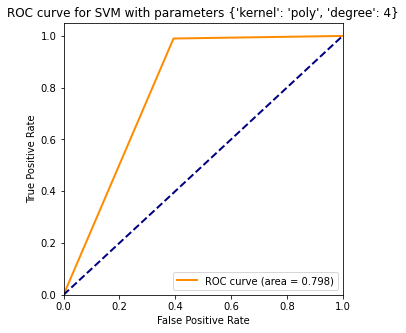

----------------------------------------------------------------------------------------------------
Results for KNN with parameters {'n_neighbors': 1}
Precision macro = 0.879
Precision for class 0 (False Positive) = 0.966
Precision for class 1 (Confirmed) = 0.792
Recall macro = 0.897
Recall for class 0 (False Positive) = 0.841
Recall for class 1 (Confirmed) = 0.953


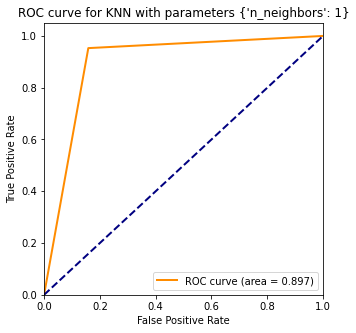

----------------------------------------------------------------------------------------------------
Results for KNN with parameters {'n_neighbors': 5}
Precision macro = 0.892
Precision for class 0 (False Positive) = 0.980
Precision for class 1 (Confirmed) = 0.804
Recall macro = 0.911
Recall for class 0 (False Positive) = 0.849
Recall for class 1 (Confirmed) = 0.973


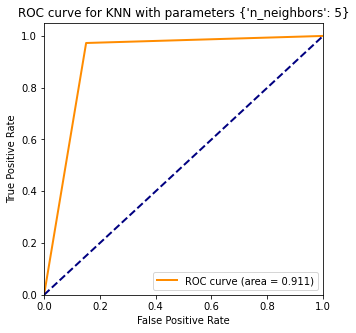

----------------------------------------------------------------------------------------------------
Results for KNN with parameters {'n_neighbors': 10}
Precision macro = 0.892
Precision for class 0 (False Positive) = 0.984
Precision for class 1 (Confirmed) = 0.801
Recall macro = 0.912
Recall for class 0 (False Positive) = 0.846
Recall for class 1 (Confirmed) = 0.978


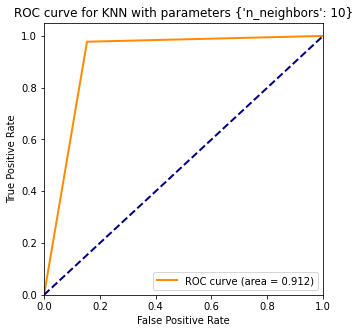

----------------------------------------------------------------------------------------------------
Results for KNN with parameters {'n_neighbors': 50}
Precision macro = 0.860
Precision for class 0 (False Positive) = 0.988
Precision for class 1 (Confirmed) = 0.732
Recall macro = 0.878
Recall for class 0 (False Positive) = 0.771
Recall for class 1 (Confirmed) = 0.985


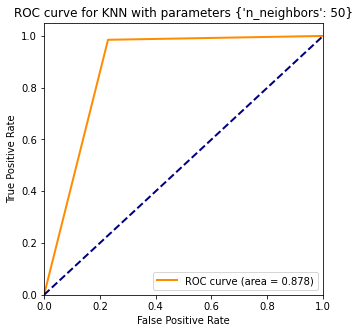

----------------------------------------------------------------------------------------------------
Results for KNN with parameters {'n_neighbors': 100}
Precision macro = 0.850
Precision for class 0 (False Positive) = 0.992
Precision for class 1 (Confirmed) = 0.708
Recall macro = 0.866
Recall for class 0 (False Positive) = 0.741
Recall for class 1 (Confirmed) = 0.990


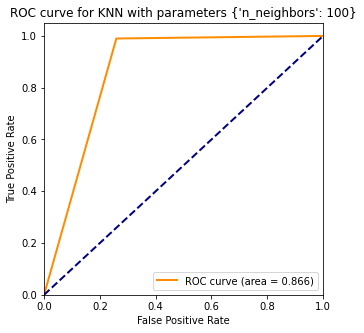

----------------------------------------------------------------------------------------------------
Results for KNN with parameters {'n_neighbors': 500}
Precision macro = 0.781
Precision for class 0 (False Positive) = 0.997
Precision for class 1 (Confirmed) = 0.564
Recall macro = 0.755
Recall for class 0 (False Positive) = 0.512
Recall for class 1 (Confirmed) = 0.998


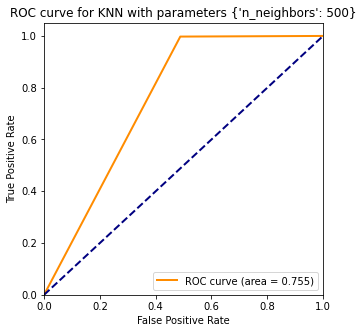

----------------------------------------------------------------------------------------------------
Results for KNN with parameters {'n_neighbors': 1000}
Precision macro = 0.748
Precision for class 0 (False Positive) = 0.996
Precision for class 1 (Confirmed) = 0.499
Recall macro = 0.682
Recall for class 0 (False Positive) = 0.366
Recall for class 1 (Confirmed) = 0.998


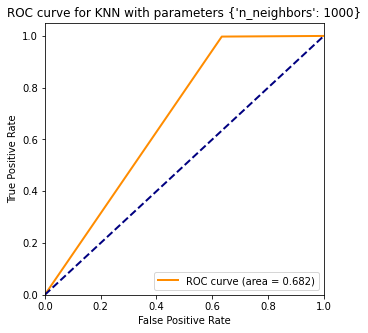

----------------------------------------------------------------------------------------------------
Results for RandomForest with parameters {'n_estimators': 1}
Precision macro = 0.933
Precision for class 0 (False Positive) = 0.964
Precision for class 1 (Confirmed) = 0.901
Recall macro = 0.940
Recall for class 0 (False Positive) = 0.934
Recall for class 1 (Confirmed) = 0.946


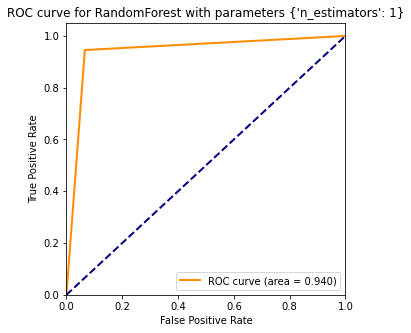

----------------------------------------------------------------------------------------------------
Results for RandomForest with parameters {'n_estimators': 5}
Precision macro = 0.965
Precision for class 0 (False Positive) = 0.972
Precision for class 1 (Confirmed) = 0.958
Recall macro = 0.964
Recall for class 0 (False Positive) = 0.973
Recall for class 1 (Confirmed) = 0.955


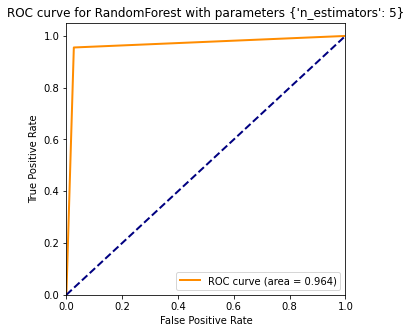

----------------------------------------------------------------------------------------------------
Results for RandomForest with parameters {'n_estimators': 10}
Precision macro = 0.964
Precision for class 0 (False Positive) = 0.967
Precision for class 1 (Confirmed) = 0.960
Recall macro = 0.961
Recall for class 0 (False Positive) = 0.975
Recall for class 1 (Confirmed) = 0.948


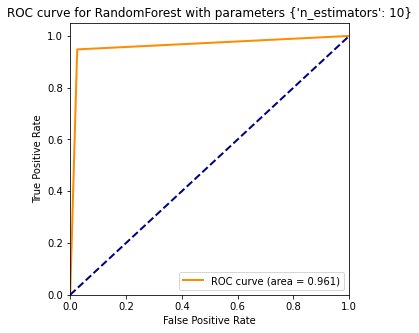

----------------------------------------------------------------------------------------------------
Results for RandomForest with parameters {'n_estimators': 50}
Precision macro = 0.969
Precision for class 0 (False Positive) = 0.981
Precision for class 1 (Confirmed) = 0.956
Recall macro = 0.971
Recall for class 0 (False Positive) = 0.972
Recall for class 1 (Confirmed) = 0.970


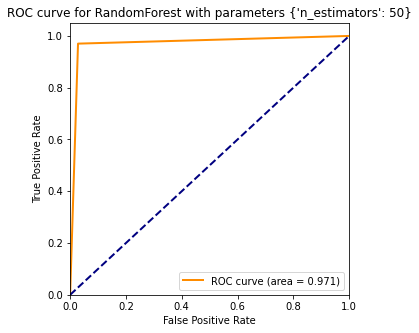

----------------------------------------------------------------------------------------------------
Results for RandomForest with parameters {'n_estimators': 100}
Precision macro = 0.964
Precision for class 0 (False Positive) = 0.979
Precision for class 1 (Confirmed) = 0.949
Recall macro = 0.967
Recall for class 0 (False Positive) = 0.967
Recall for class 1 (Confirmed) = 0.968


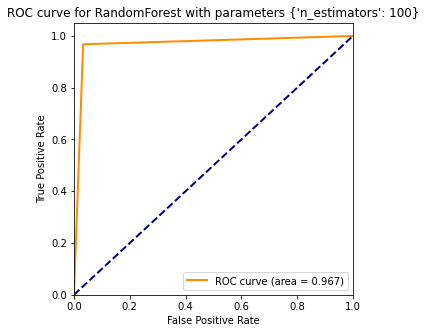

----------------------------------------------------------------------------------------------------
Results for RandomForest with parameters {'n_estimators': 200}
Precision macro = 0.965
Precision for class 0 (False Positive) = 0.979
Precision for class 1 (Confirmed) = 0.951
Recall macro = 0.968
Recall for class 0 (False Positive) = 0.969
Recall for class 1 (Confirmed) = 0.968


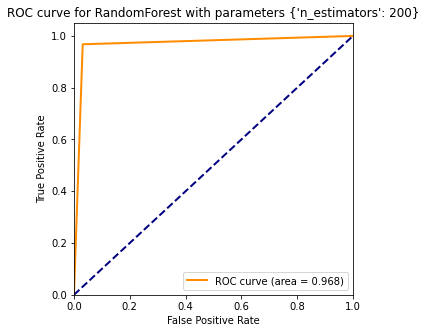

----------------------------------------------------------------------------------------------------
Results for RandomForest with parameters {'n_estimators': 500}
Precision macro = 0.967
Precision for class 0 (False Positive) = 0.979
Precision for class 1 (Confirmed) = 0.954
Recall macro = 0.969
Recall for class 0 (False Positive) = 0.970
Recall for class 1 (Confirmed) = 0.968


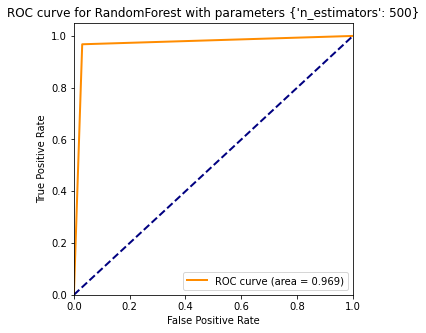

----------------------------------------------------------------------------------------------------
Results for GradientTreeBoosting with parameters {'n_estimators': 1}
Precision macro = 0.306
Precision for class 0 (False Positive) = 0.612
Precision for class 1 (Confirmed) = 0.000
Recall macro = 0.500
Recall for class 0 (False Positive) = 1.000
Recall for class 1 (Confirmed) = 0.000


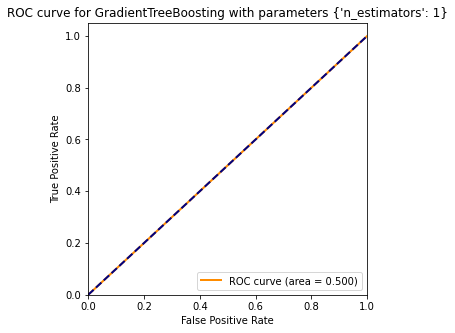

----------------------------------------------------------------------------------------------------
Results for GradientTreeBoosting with parameters {'n_estimators': 5}
Precision macro = 0.938
Precision for class 0 (False Positive) = 0.944
Precision for class 1 (Confirmed) = 0.932
Recall macro = 0.934
Recall for class 0 (False Positive) = 0.958
Recall for class 1 (Confirmed) = 0.911


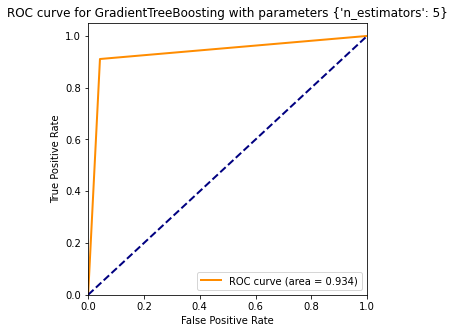

----------------------------------------------------------------------------------------------------
Results for GradientTreeBoosting with parameters {'n_estimators': 10}
Precision macro = 0.940
Precision for class 0 (False Positive) = 0.962
Precision for class 1 (Confirmed) = 0.918
Recall macro = 0.944
Recall for class 0 (False Positive) = 0.947
Recall for class 1 (Confirmed) = 0.941


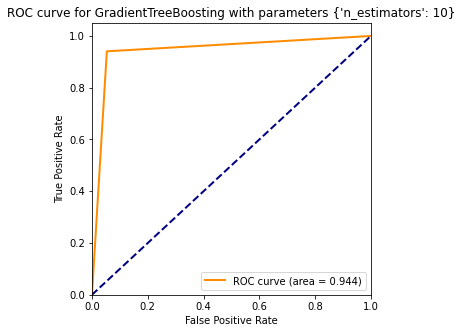

----------------------------------------------------------------------------------------------------
Results for GradientTreeBoosting with parameters {'n_estimators': 50}
Precision macro = 0.966
Precision for class 0 (False Positive) = 0.984
Precision for class 1 (Confirmed) = 0.947
Recall macro = 0.970
Recall for class 0 (False Positive) = 0.965
Recall for class 1 (Confirmed) = 0.975


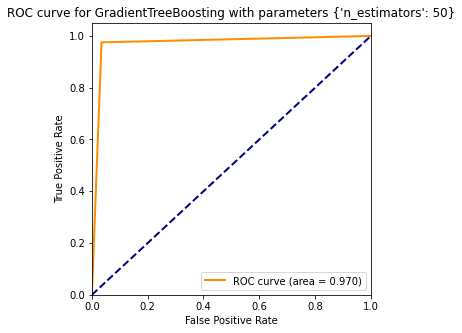

----------------------------------------------------------------------------------------------------
Results for GradientTreeBoosting with parameters {'n_estimators': 100}
Precision macro = 0.970
Precision for class 0 (False Positive) = 0.990
Precision for class 1 (Confirmed) = 0.950
Recall macro = 0.976
Recall for class 0 (False Positive) = 0.967
Recall for class 1 (Confirmed) = 0.985


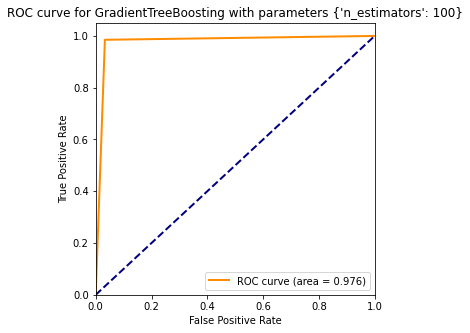

----------------------------------------------------------------------------------------------------
Results for GradientTreeBoosting with parameters {'n_estimators': 200}
Precision macro = 0.968
Precision for class 0 (False Positive) = 0.990
Precision for class 1 (Confirmed) = 0.945
Recall macro = 0.975
Recall for class 0 (False Positive) = 0.964
Recall for class 1 (Confirmed) = 0.985


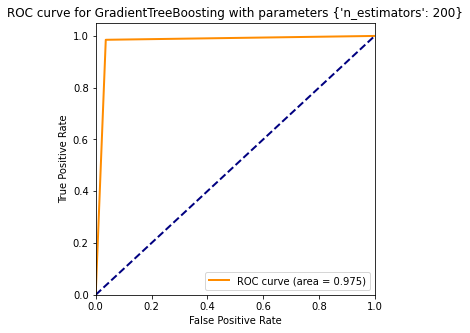

----------------------------------------------------------------------------------------------------
Results for GradientTreeBoosting with parameters {'n_estimators': 500}
Precision macro = 0.968
Precision for class 0 (False Positive) = 0.992
Precision for class 1 (Confirmed) = 0.943
Recall macro = 0.975
Recall for class 0 (False Positive) = 0.962
Recall for class 1 (Confirmed) = 0.988


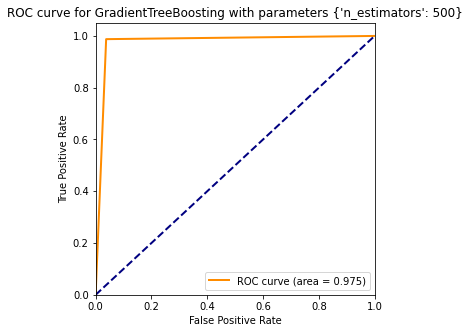

In [21]:
for _, result in results.iterrows():
    print('-' * 100)
    print(f"Results for {result['model_name']} with parameters {result['model_params']}")
    
    precision_macro = precision_score(test_y, result['y_pred'], average='macro', zero_division=0)
    precision_0 = precision_score(test_y, result['y_pred'], average='binary', pos_label=0, zero_division=0)
    precision_1 = precision_score(test_y, result['y_pred'], average='binary', pos_label=1, zero_division=0)
    recall_macro = recall_score(test_y, result['y_pred'], average='macro', zero_division=0)
    recall_0 = recall_score(test_y, result['y_pred'], average='binary', pos_label=0, zero_division=0)
    recall_1 = recall_score(test_y, result['y_pred'], average='binary', pos_label=1, zero_division=0)
    
    print(f'Precision macro = {precision_macro:.3f}')
    print(f'Precision for class 0 (False Positive) = {precision_0:.3f}')
    print(f'Precision for class 1 (Confirmed) = {precision_1:.3f}')
    print(f'Recall macro = {recall_macro:.3f}')
    print(f'Recall for class 0 (False Positive) = {recall_0:.3f}')
    print(f'Recall for class 1 (Confirmed) = {recall_1:.3f}')
    
    fpr, tpr, _ = roc_curve(test_y, result['y_pred'])
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, lw=2, color='darkorange', label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC curve for {result['model_name']} with parameters {result['model_params']}")
    plt.legend(loc="lower right")
    plt.show()

## Conclusion

We can see that this data contains mostly data points that are simple to separate with a simple function, given the good results simpler models achieved. This usually happens when a few set of features can express the data well.

But as we require best classifications, our more complex models excels at separating it. This is due to few data points being harder to classificate correctly, as they are mixed within other groups with different classes.

In [22]:
pca = PCA(n_components=2, random_state=RANDOM_SEED)
pca_results = pca.fit_transform(x)

print(f'Explained variation per principal component: {pca.explained_variance_ratio_} = {pca.explained_variance_ratio_.sum()}')

tsne = TSNE(n_components=2, random_state=RANDOM_SEED)
tsne_results = tsne.fit_transform(pca_results)

Explained variation per principal component: [0.76941777 0.22682921] = 0.9962469708968663


As we can see, the PCA with only 2 components achieve the Explaned Variation of the data by an impressive $99.6\%$. This proves the point that even simpler models using only this two features can well express our classification and achieve great results.

In the following plot we can see that even a linear separation can separate the two groups in a sufficient way.

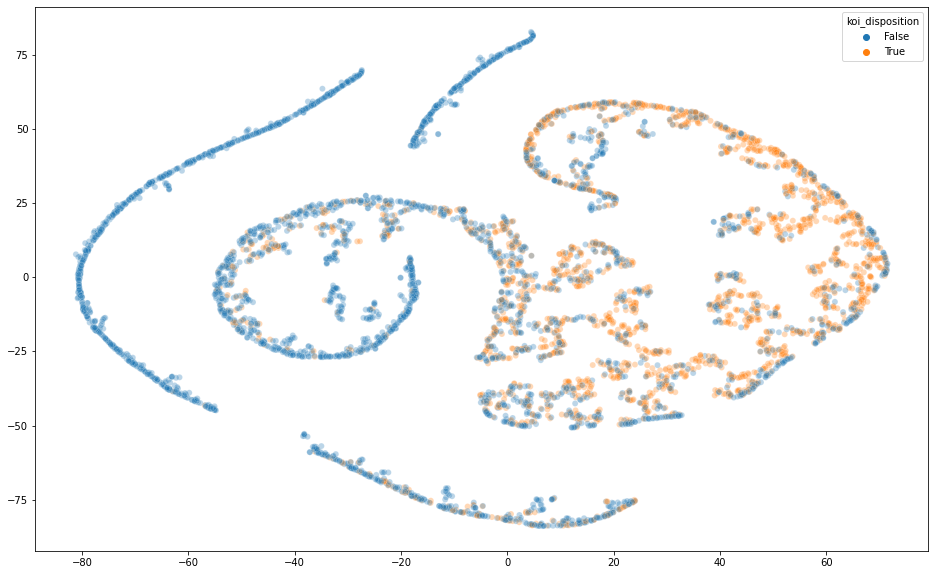

In [23]:
plt.figure(figsize=(16,10))
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue=y, legend="full", alpha=0.3)
plt.show()

So, if the objective is to achieve a relatively good classification result with a simple model, I would choose the SVM with a linear kernel (kernel='linear') as my model.

But if the objective is to achieve even better classification results with more complex models, I would choose the Gradient Tree Boosting model with 200 estimators (n_estimators=200) as my model.